<a href="https://colab.research.google.com/github/pravinkr/resnet50-cifar10-keras/blob/master/cifar_10_with_resnet_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Mon Nov 21 20:34:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Simple CNN model for CIFAR-10 dataset
import numpy as np

# Simple CNN model for CIFAR-10
import numpy as np
import os
from keras.datasets import cifar10, cifar100
from keras.models import Sequential, Model
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD, Adam
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.initializers import glorot_uniform
from keras import backend as K

from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

import skimage
from skimage.util import img_as_ubyte


In [ ]:
#Defining Variables

#Data set information
DATASET = 'cifar-10'
#DATASET = 'cifar-100'
input_shape=(32,32,3)

if DATASET == 'cifar-10':
  num_classes = 10
elif DATASET == 'cifar-100':
  num_classes = 100

#Model Parameters

#model_type = 'Alexnet'
model_type = 'ResNet50'

epochs = 50
lrate = 0.01
decay = lrate/epochs
batch_size = 32

data_augmentation = False
flow_from_dir = False

subtract_mean = True
seed = 7
np.random.seed(seed)

validate_dir = os.path.join("data","test")
train_dir = os.path.join("data","train")

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')

#model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
model_name = DATASET+'_'+'%s_model.{epoch:03d}.h5' % model_type

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
print("Model Type: ",model_type)
print("Model File: ",filepath)

Model Type:  ResNet50
Model File:  /content/saved_models/cifar-10_ResNet50_model.{epoch:03d}.h5


In [ ]:
if flow_from_dir:
  if DATASET == 'cifar-10':
    %pip install cifar2png
    %cifar2png cifar10 "data"

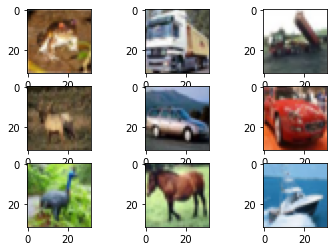

In [ ]:
if not flow_from_dir:
  #load data
  if DATASET == 'cifar-10':
    (X_train, y_train),(X_test,y_test) = cifar10.load_data()
    X_train.shape, X_test.shape, X_train.shape[1:],X_train.dtype
  elif DATASET == 'cifar-100':
    (X_train, y_train),(X_test,y_test) = cifar100.load_data()
    X_train.shape, X_test.shape, X_train.shape[1:],X_train.dtype

  #Plot data
  for i in range(0,9):
    plt.subplot(330+1+i)
    plt.imshow(X_train[i])
  plt.show() 
  


In [ ]:
def convert_to_imagenet_size(images):
  tmp_images = []
  for image in images:
    image = skimage.transform.resize(image,(224,224),mode='constant')
    image = img_as_ubyte(image)
    tmp_images.append(image)
  return np.array(tmp_images)

In [ ]:
#Data Normalization
if not flow_from_dir:
  if not data_augmentation:
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train = X_train/255.
    X_test = X_test/255.

    if subtract_mean:
      X_train_mean = np.mean(X_train)
      X_train -= X_train_mean
      X_test_mean = np.mean(X_test)
      X_test -= X_test_mean

  print(y_train.shape, y_test.shape)

(50000, 1) (10000, 1)


In [ ]:
if not flow_from_dir:
  y_train = np_utils.to_categorical(y_train)
  y_test = np_utils.to_categorical(y_test)
  print(y_train.shape, y_test.shape)

(50000, 10) (10000, 10)


In [ ]:
#num_classes = y_train.shape[1]
#input_shape=X_train.shape[1:]

input_shape,num_classes

((32, 32, 3), 10)

In [ ]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [ ]:
def ResNet50(input_shape=(32, 32, 3), classes=10):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((1,1), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
#Define Alexnet Model
def AlexnetModel(input_shape,num_classes):
  model = Sequential()
  model.add(Conv2D(filters=96,kernel_size=(3,3),strides=(4,4),input_shape=input_shape, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(256,(5,5),padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
  model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
  model.add(Conv2D(256,(3,3),padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(num_classes,activation='softmax'))

  #model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

  #model.summary()
  return model

In [ ]:
def get_model(input_shape,num_classes):
  # Create the model - Normal model with CNN, dropouts and MaxPooling.
  # This model gives accuracy of 77% on the test set after 25 epochs

  model = Sequential()

  #model.add(Conv2D(32,(3,3),input_shape=(32,32,3),padding='same',activation='relu'))
  model.add(Conv2D(32,(3,3),input_shape=input_shape,padding='same',activation='relu'))
  model.add(Dropout(0.2))

  model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
  model.add(Dropout(0.2))

  model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
  model.add(Dropout(0.2))

  model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())
  model.add(Dropout(0.2))

  model.add(Dense(1024,activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(512,activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(num_classes,activation='softmax'))

  return model



In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [ ]:
# Prepare callbacks for model saving and for learning rate adjustment.

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler,early_stopping]


In [ ]:
#model = get_model(input_shape,num_classes)
if model_type == 'Alexnet':
  #input_shape = (224,224,3)
  model = AlexnetModel(input_shape,num_classes)
elif model_type == 'ResNet50':
  model = ResNet50(input_shape,num_classes)
else:
  model = get_model(input_shape,num_classes)

# Compile model

#optimizer = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss= 'categorical_crossentropy' , optimizer=optimizer, metrics=[ 'accuracy' ])
print("Model Summary of ",model_type)
print(model.summary())



Model Summary of  ResNet50
Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 38, 38, 3)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 16, 16, 64)   9472        ['zero_padding2d_1[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 16, 16, 64)   256        

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 bn3c_branch2b (BatchNormalizat  (None, 4, 4, 128)   512         ['res3c_branch2b[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_66 (Activation)     (None, 4, 4, 128)    0           ['bn3c_branch2b[0][0]']          
                                                                                                  
 res3c_branch2c (Conv2D)        (None, 4, 4, 512)    66048       ['activation_66[0][0]']          
                                                                                                  
 bn3c_branch2c (BatchNormalizat  (None, 4, 4, 512)   2048        ['res3c_branch2c[0][0]']         
 ion)                                                                                             
                                                                                                  
 add_21 (A

In [ ]:
if data_augmentation:
	print('Using real-time data augmentation.')
	# This will do preprocessing and realtime data augmentation:
	datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=True,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.2,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.2,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).


if not flow_from_dir:
	if not data_augmentation:
		print('Not using data augmentation.')
		history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          shuffle=True,
          callbacks=callbacks)
	else:   
		print("model using data from downloaded dataset in memoory")
		datagen.fit(X_train)
		# Fit the model on the batches generated by datagen.flow().
		history = model.fit_generator(datagen.flow(X_train, y_train,
                                 batch_size=batch_size),
                                 epochs=epochs,
                                 validation_data=datagen.flow((X_test, y_test),batch_size=batch_size),
                                 workers=4,
                                 callbacks=callbacks)
  
	scores = model.evaluate(X_test, y_test, verbose=1)

else:
	# generator for reading train data from folder

	print('Model fit using flow from directory')


	train_generator = datagen.flow_from_directory(
      train_dir,
      target_size = (224, 224),
      color_mode = 'rgb',
      batch_size = batch_size,
      class_mode = 'categorical',
      shuffle=False,
      seed=42
      )
	#
	# generator for reading validation data from folder

	validation_generator = datagen.flow_from_directory(
      validate_dir,
      target_size = (224, 224),
      color_mode = 'rgb',
      batch_size = batch_size,
      class_mode = 'categorical',
      shuffle=False,
      seed=42)
  
	STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
	STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
  
	history = model.fit_generator(generator=train_generator,
                steps_per_epoch=STEP_SIZE_TRAIN,
                validation_data=validation_generator,
                validation_steps=STEP_SIZE_VALID,
                epochs=10,
                callbacks=callbacks
                )
  
	scores = model.evaluate_generator(generator=validation_generator,
                           steps=STEP_SIZE_VALID, verbose=1)

	#Predict the output
	''' Use when to Predict the output
	STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
	test_generator.reset()
	pred=model.predict_generator(test_generator,
                               steps=STEP_SIZE_TEST,
                               verbose=1)

	'''
# Save model and weights



# Score trained model.

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Not using data augmentation.
Learning rate:  0.001
Epoch 1/50
1562/1563 [============================>.] - ETA: 0s - loss: 2.2855 - accuracy: 0.3044

1563/1563 [==============================] - 74s 44ms/step - loss: 2.2853 - accuracy: 0.3044 - val_loss: 2.1128 - val_accuracy: 0.3287 - lr: 0.0010
Learning rate:  0.001
Epoch 2/50
1562/1563 [============================>.] - ETA: 0s - loss: 2.0861 - accuracy: 0.3433

1563/1563 [==============================] - 66s 42ms/step - loss: 2.0863 - accuracy: 0.3433 - val_loss: 2.6532 - val_accuracy: 0.2493 - lr: 0.0010
Learning rate:  0.001
Epoch 3/50
1562/1563 [============================>.] - ETA: 0s - loss: 2.1190 - accuracy: 0.3105

1563/1563 [==============================] - 66s 42ms/step - loss: 2.1188 - accuracy: 0.3106 - val_loss: 12.0507 - val_accuracy: 0.3601 - lr: 0.0010
Learning rate:  0.001
Epoch 4/50
1563/1563 [==============================] - ETA: 0s - loss: 1.9209 - accuracy: 0.3654

1563/1563 [==============================] - 66s 42ms/step - loss: 1.9209 - accuracy: 0.3654 - val_loss: 1.8980 - val_accuracy: 0.3664 - lr: 0.0010
Learning rate:  0.001
Epoch 5/50
1563/1563 [==============================] - ETA: 0s - loss: 1.9435 - accuracy: 0.3418

1563/1563 [==============================] - 66s 42ms/step - loss: 1.9435 - accuracy: 0.3418 - val_loss: 6.9381 - val_accuracy: 0.3885 - lr: 0.0010
Learning rate:  0.001
Epoch 6/50
1562/1563 [============================>.] - ETA: 0s - loss: 1.8363 - accuracy: 0.3841

1563/1563 [==============================] - 66s 42ms/step - loss: 1.8363 - accuracy: 0.3840 - val_loss: 2.1317 - val_accuracy: 0.4058 - lr: 0.0010
Learning rate:  0.001
Epoch 7/50
1563/1563 [==============================] - ETA: 0s - loss: 1.7083 - accuracy: 0.4106

1563/1563 [==============================] - 66s 42ms/step - loss: 1.7083 - accuracy: 0.4106 - val_loss: 1.5743 - val_accuracy: 0.4355 - lr: 0.0010
Learning rate:  0.001
Epoch 8/50
1563/1563 [==============================] - ETA: 0s - loss: 1.5822 - accuracy: 0.4434

1563/1563 [==============================] - 66s 42ms/step - loss: 1.5822 - accuracy: 0.4434 - val_loss: 1.3716 - val_accuracy: 0.4984 - lr: 0.0010
Learning rate:  0.001
Epoch 9/50
1563/1563 [==============================] - ETA: 0s - loss: 1.4292 - accuracy: 0.5003

1563/1563 [==============================] - 67s 43ms/step - loss: 1.4292 - accuracy: 0.5003 - val_loss: 1.3205 - val_accuracy: 0.5324 - lr: 0.0010
Learning rate:  0.001
Epoch 10/50
1562/1563 [============================>.] - ETA: 0s - loss: 1.3439 - accuracy: 0.5326

1563/1563 [==============================] - 68s 43ms/step - loss: 1.3438 - accuracy: 0.5326 - val_loss: 1.1380 - val_accuracy: 0.5927 - lr: 0.0010
Learning rate:  0.001
Epoch 11/50
1562/1563 [============================>.] - ETA: 0s - loss: 1.2390 - accuracy: 0.5686

1563/1563 [==============================] - 66s 42ms/step - loss: 1.2390 - accuracy: 0.5686 - val_loss: 1.1268 - val_accuracy: 0.6146 - lr: 0.0010
Learning rate:  0.001
Epoch 12/50
1563/1563 [==============================] - ETA: 0s - loss: 1.1416 - accuracy: 0.6060

1563/1563 [==============================] - 66s 42ms/step - loss: 1.1416 - accuracy: 0.6060 - val_loss: 1.0697 - val_accuracy: 0.6226 - lr: 0.0010
Learning rate:  0.001
Epoch 13/50
1563/1563 [==============================] - ETA: 0s - loss: 0.9978 - accuracy: 0.6535

1563/1563 [==============================] - 66s 42ms/step - loss: 0.9978 - accuracy: 0.6535 - val_loss: 1.7091 - val_accuracy: 0.5638 - lr: 0.0010
Learning rate:  0.001
Epoch 14/50
1563/1563 [==============================] - ETA: 0s - loss: 0.9067 - accuracy: 0.6832

1563/1563 [==============================] - 66s 42ms/step - loss: 0.9067 - accuracy: 0.6832 - val_loss: 0.8953 - val_accuracy: 0.6827 - lr: 0.0010
Learning rate:  0.001
Epoch 15/50
1563/1563 [==============================] - ETA: 0s - loss: 0.8286 - accuracy: 0.7150

1563/1563 [==============================] - 66s 42ms/step - loss: 0.8286 - accuracy: 0.7150 - val_loss: 0.9332 - val_accuracy: 0.6811 - lr: 0.0010
Learning rate:  0.001
Epoch 16/50
1563/1563 [==============================] - ETA: 0s - loss: 0.7252 - accuracy: 0.7475

1563/1563 [==============================] - 66s 42ms/step - loss: 0.7252 - accuracy: 0.7475 - val_loss: 0.8271 - val_accuracy: 0.7112 - lr: 0.0010
Learning rate:  0.001
Epoch 17/50
1563/1563 [==============================] - ETA: 0s - loss: 0.6426 - accuracy: 0.7769

1563/1563 [==============================] - 66s 42ms/step - loss: 0.6426 - accuracy: 0.7769 - val_loss: 0.8703 - val_accuracy: 0.7004 - lr: 0.0010
Learning rate:  0.001
Epoch 18/50
1562/1563 [============================>.] - ETA: 0s - loss: 0.5701 - accuracy: 0.8035

1563/1563 [==============================] - 67s 43ms/step - loss: 0.5700 - accuracy: 0.8036 - val_loss: 0.8040 - val_accuracy: 0.7269 - lr: 0.0010
Learning rate:  0.001
Epoch 19/50
1563/1563 [==============================] - ETA: 0s - loss: 0.5218 - accuracy: 0.8185

1563/1563 [==============================] - 67s 43ms/step - loss: 0.5218 - accuracy: 0.8185 - val_loss: 0.8065 - val_accuracy: 0.7316 - lr: 0.0010
Learning rate:  0.001
Epoch 20/50
1563/1563 [==============================] - ETA: 0s - loss: 0.4365 - accuracy: 0.8478

1563/1563 [==============================] - 66s 42ms/step - loss: 0.4365 - accuracy: 0.8478 - val_loss: 0.8143 - val_accuracy: 0.7342 - lr: 0.0010
Learning rate:  0.001
Epoch 21/50
1563/1563 [==============================] - ETA: 0s - loss: 0.3812 - accuracy: 0.8665

1563/1563 [==============================] - 66s 42ms/step - loss: 0.3812 - accuracy: 0.8665 - val_loss: 0.8851 - val_accuracy: 0.7294 - lr: 0.0010
Learning rate:  0.001
Epoch 22/50
1563/1563 [==============================] - ETA: 0s - loss: 0.3366 - accuracy: 0.8820

1563/1563 [==============================] - 66s 42ms/step - loss: 0.3366 - accuracy: 0.8820 - val_loss: 0.8777 - val_accuracy: 0.7383 - lr: 0.0010
Learning rate:  0.001
Epoch 23/50
1563/1563 [==============================] - ETA: 0s - loss: 0.2845 - accuracy: 0.9010

313/313 [==============================] - 5s 16ms/step - loss: 0.8040 - accuracy: 0.7269
Test loss: 0.8039708137512207
Test accuracy: 0.7268999814987183


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


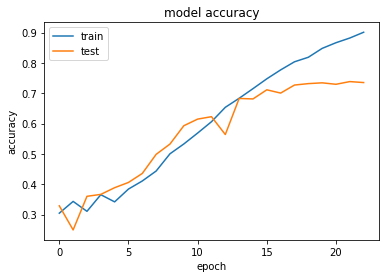

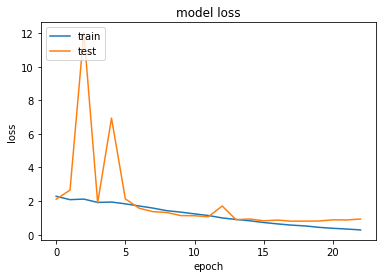

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools



In [ ]:
predictions = model.predict(X_test, verbose=0)
yitest = np.argmax(y_test, axis=1)

yptest = np.argmax(predictions, axis=1)
print (yitest)
print (yptest)

[3 8 8 ... 5 1 7]
[3 8 8 ... 5 0 7]


In [ ]:
cfm = confusion_matrix(yitest, yptest)
print (cfm)

[[727  19  43  25  22   4   6   9 110  35]
 [ 19 825   7   7   3   8   8   4  34  85]
 [ 63   4 625  57  78  70  44  36  18   5]
 [ 14   7  74 535  54 213  43  35  13  12]
 [ 21   2  67  75 664  43  32  85   7   4]
 [  9   2  40 143  38 679  20  49   8  12]
 [  8   4  41  51  42  58 767  10  11   8]
 [ 15   2  26  41  37  76   5 781   2  15]
 [ 33  31  10  13   8   8   3   4 873  17]
 [ 37  85   7  17   0   7   6  13  35 793]]


In [ ]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization


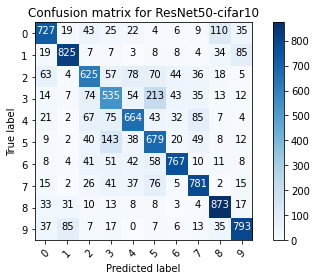

In [ ]:
plot_confusion_matrix(cfm, classes=range(10), 
                      title='Confusion matrix for ResNet50-cifar10')

In [ ]:
cfm = confusion_matrix(yitest, yptest)
print(cfm/1000)  

[[0.727 0.019 0.043 0.025 0.022 0.004 0.006 0.009 0.11  0.035]
 [0.019 0.825 0.007 0.007 0.003 0.008 0.008 0.004 0.034 0.085]
 [0.063 0.004 0.625 0.057 0.078 0.07  0.044 0.036 0.018 0.005]
 [0.014 0.007 0.074 0.535 0.054 0.213 0.043 0.035 0.013 0.012]
 [0.021 0.002 0.067 0.075 0.664 0.043 0.032 0.085 0.007 0.004]
 [0.009 0.002 0.04  0.143 0.038 0.679 0.02  0.049 0.008 0.012]
 [0.008 0.004 0.041 0.051 0.042 0.058 0.767 0.01  0.011 0.008]
 [0.015 0.002 0.026 0.041 0.037 0.076 0.005 0.781 0.002 0.015]
 [0.033 0.031 0.01  0.013 0.008 0.008 0.003 0.004 0.873 0.017]
 [0.037 0.085 0.007 0.017 0.    0.007 0.006 0.013 0.035 0.793]]


Normalized confusion matrix


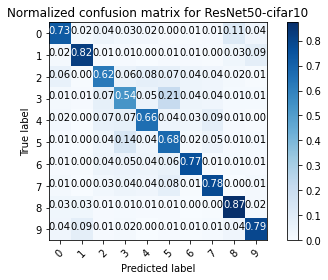

In [ ]:
plot_confusion_matrix(cfm, normalize=True, classes=range(10), 
                      title='Normalized confusion matrix for ResNet50-cifar10')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/ECE6930/ResNet-50')

In [ ]:
from tensorflow import keras
model01 = keras.models.load_model('/content/drive/MyDrive/ECE6930/ResNet-50')

In [ ]:
predictions = model01.predict(X_test, verbose=0)
yitest = np.argmax(y_test, axis=1)

yptest = np.argmax(predictions, axis=1)
print (yitest)
print (yptest)

[3 8 8 ... 5 1 7]
[3 8 8 ... 5 0 7]


In [ ]:
cfm = confusion_matrix(yitest, yptest)
print (cfm)

[[727  19  43  25  22   4   6   9 110  35]
 [ 19 825   7   7   3   8   8   4  34  85]
 [ 63   4 625  57  78  70  44  36  18   5]
 [ 14   7  74 535  54 213  43  35  13  12]
 [ 21   2  67  75 664  43  32  85   7   4]
 [  9   2  40 143  38 679  20  49   8  12]
 [  8   4  41  51  42  58 767  10  11   8]
 [ 15   2  26  41  37  76   5 781   2  15]
 [ 33  31  10  13   8   8   3   4 873  17]
 [ 37  85   7  17   0   7   6  13  35 793]]


In [ ]:
model01.save("my_h5_model.h5")

In [ ]:
! cd /content/drive/MyDrive/ECE6930

In [ ]:
model01.save("/content/drive/MyDrive/ECE6930/ResNet50-1121-01/my_h5_model.h5")

In [ ]:
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/ECE6930/ResNet50-1121-01/my_h5_model.h5")

In [ ]:
predictions = reconstructed_model.predict(X_test, verbose=0)
yitest = np.argmax(y_test, axis=1)

yptest = np.argmax(predictions, axis=1)
print (yitest)
print (yptest)

[3 8 8 ... 5 1 7]
[3 8 8 ... 5 0 7]


In [ ]:
cfm = confusion_matrix(yitest, yptest)
print (cfm)

[[727  19  43  25  22   4   6   9 110  35]
 [ 19 825   7   7   3   8   8   4  34  85]
 [ 63   4 625  57  78  70  44  36  18   5]
 [ 14   7  74 535  54 213  43  35  13  12]
 [ 21   2  67  75 664  43  32  85   7   4]
 [  9   2  40 143  38 679  20  49   8  12]
 [  8   4  41  51  42  58 767  10  11   8]
 [ 15   2  26  41  37  76   5 781   2  15]
 [ 33  31  10  13   8   8   3   4 873  17]
 [ 37  85   7  17   0   7   6  13  35 793]]
